### Q1. Downloading the data
We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

* 1054112
* 1154112
* 1254112
* 1354112

In [1]:
! wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet -P data/
! wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet -P data/

--2022-05-22 04:57:53--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.216.154.36
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.216.154.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11886281 (11M) [binary/octet-stream]
Saving to: ‘data/fhv_tripdata_2021-01.parquet’

fhv_tripdata_2021-0 100%[===================>]  11.33M  48.7MB/s    in 0.2s    

2022-05-22 04:57:53 (48.7 MB/s) - ‘data/fhv_tripdata_2021-01.parquet’ saved [11886281/11886281]

--2022-05-22 04:57:53--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.216.154.36
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.216.154.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10645466 (10M) [binary/octet-stream]
Saving to: ‘data/fhv_tripdata_2021-02.pa

In [2]:
import pandas as pd

In [3]:
jan_data = pd.read_parquet("data/fhv_tripdata_2021-01.parquet")
feb_data = pd.read_parquet("data/fhv_tripdata_2021-02.parquet")

In [4]:
# Number of records
print(f"Number of records in January data: {jan_data.shape[0]}")

Number of records in January data: 1154112


### Q2. Computing duration
Now let's compute the `duration` variable. It should contain the duration of a ride in minutes.

In [5]:
jan_data['duration'] = jan_data['dropOff_datetime'] - jan_data['pickup_datetime']
jan_data['duration'] = jan_data['duration'].apply(lambda x: x.total_seconds()/60)
print(f"Average Trip Duration in January was {jan_data['duration'].mean()} minutes")

Average Trip Duration in January was 19.1672240937939 minutes


### Data preparation
Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


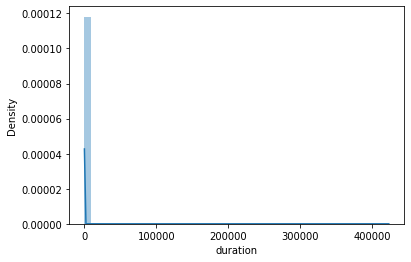

In [7]:
sns.distplot(jan_data.duration)

In [8]:
processed_jan_data = jan_data[(jan_data.duration >=1) & (jan_data.duration <= 60)]
print(f"Number of records dropped: {jan_data.shape[0] - processed_jan_data.shape[0]}")

Number of records dropped: 44286


### Q3. Missing values
The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.



In [9]:
processed_jan_data.columns

Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number',
       'duration'],
      dtype='object')

In [10]:
columns = ['PUlocationID', 'DOlocationID', 'duration']
processed_jan_data = processed_jan_data[columns]
processed_jan_data.dtypes

PUlocationID    float64
DOlocationID    float64
duration        float64
dtype: object

In [11]:
print(f"Number of missing values for Pickup Location Id: {processed_jan_data['PUlocationID'].isna().sum()}") 
processed_jan_data['PUlocationID'].fillna(-1, inplace=True)
processed_jan_data['DOlocationID'].fillna(-1, inplace=True)

print(f"Ratio: {(processed_jan_data['PUlocationID'] == -1).sum() / processed_jan_data.shape[0]}")

Number of missing values for Pickup Location Id: 927008
Ratio: 0.8352732770722617


### Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. 

We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries

Fit a dictionary vectorizer

Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

In [12]:
from sklearn.feature_extraction import DictVectorizer

categorical_columns = ['PUlocationID', 'DOlocationID']
processed_jan_data[categorical_columns] = processed_jan_data[categorical_columns].astype(str)

feature_dicts = processed_jan_data[categorical_columns].to_dict(orient='records')

In [13]:
feature_dicts[:10]

[{'DOlocationID': '-1.0', 'PUlocationID': '-1.0'},
 {'DOlocationID': '-1.0', 'PUlocationID': '-1.0'},
 {'DOlocationID': '72.0', 'PUlocationID': '-1.0'},
 {'DOlocationID': '61.0', 'PUlocationID': '-1.0'},
 {'DOlocationID': '71.0', 'PUlocationID': '-1.0'},
 {'DOlocationID': '91.0', 'PUlocationID': '-1.0'},
 {'DOlocationID': '39.0', 'PUlocationID': '-1.0'},
 {'DOlocationID': '37.0', 'PUlocationID': '-1.0'},
 {'DOlocationID': '39.0', 'PUlocationID': '-1.0'},
 {'DOlocationID': '72.0', 'PUlocationID': '-1.0'}]

In [14]:
dv = DictVectorizer()

X_train = dv.fit_transform(feature_dicts)

print(f"Number of columns in the feature matrix is : {X_train.shape[1]}")

Number of columns in the feature matrix is : 525


### Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters

Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [15]:
y_train = processed_jan_data['duration'].values

In [16]:
y_train

array([17.        , 17.        ,  8.28333333, ..., 16.2       ,
       19.43333333, 36.        ])

In [17]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [18]:
from sklearn.metrics import mean_squared_error
y_pred = lr.predict(X_train)
print(f"RMSE on training data is: {mean_squared_error(y_train, y_pred, squared=False)}")

RMSE on training data is: 10.528519107210744


### Q6. Evaluating the model
Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation?

In [19]:
def preprocess_val_data(val_data, dv):
  val_data['duration'] = val_data['dropOff_datetime'] - val_data['pickup_datetime']
  val_data['duration'] = val_data['duration'].apply(lambda x: x.total_seconds()/60)

  val_data = val_data[(val_data.duration >= 1) & (val_data.duration <= 60 )]


  columns = ['PUlocationID', 'DOlocationID', 'duration']
  processed_val_data = val_data[columns]

  processed_val_data['PUlocationID'].fillna(-1, inplace=True)
  processed_val_data['DOlocationID'].fillna(-1, inplace=True)

  categorical_columns = ['PUlocationID', 'DOlocationID']
  processed_val_data[categorical_columns] = processed_val_data[categorical_columns].astype(str)
  feature_dicts = processed_val_data[categorical_columns].to_dict(orient='records')
  
  X_val = dv.transform(feature_dicts)
  y_val = processed_val_data['duration'].values

  return X_val, y_val



In [20]:
X_val, y_val = preprocess_val_data(feb_data, dv)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [21]:
y_val_pred = lr.predict(X_val)
print(f"RMSE on validation data is {mean_squared_error(y_val, y_val_pred, squared=False)}")

RMSE on validation data is 11.014283196111764
